# 通用的管道接口

Pipeline类不但可用于预处理和分类，实际上还可以将任意数量的估计器连接住一起。例如，你可以构建一个包含特征提取、特征选择、缩放和分类的管道，总共有4个步骤。同样，最后一步可以用回归或聚类代替分类。

对于管道中估计器的唯一要求就是，除了最后一步之外的所有步骤都需要具行transform 方法，这样它们可以生成新的数据表示，以供下一个步骤使用。 

在调用Pipeline.fit的过程中， 管道内部依欢对每个步骤调用fit和transform ，其输入是前一个步骤中transform方法的输出。对于管道中的最后一步，则仅调用fit。 

忽略某些细枝末节，其实现方法如下所示,请记住，pipeline.steps是由元组组成的列表， 所以 pipeline.steps[0][1]是第一个估计器，pipeline.steps[1][1]是第二个估计器，以此类推：

In [1]:
def fit(self, x, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 遍历除了最后一步外所有步骤
        # 对数据进行变换
        X_transformed = steps[1].transform(X_transformed, y)
    # 利用最后一步进行预测
    return self.steps[-1][1].predict(X_transformed, y)

使用Pipeline进行预测时, 我们同样利用除最后一步之外的所有步骤对数据进行变换 (transform), 然后对最后一步调用predict：

In [2]:
def fit(self, x):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 遍历除了最后一步外所有步骤
        # 对数据进行变换
        X_transformed = steps[1].transform(X_transformed)
    # 利用最后一步进行预测
    return self.steps[-1][1].predict(X_transformed)

整个过程如下图所示，其中包含两个变换器(transformer) T1和 T2，还有一个分类器 (叫作Classifier)。

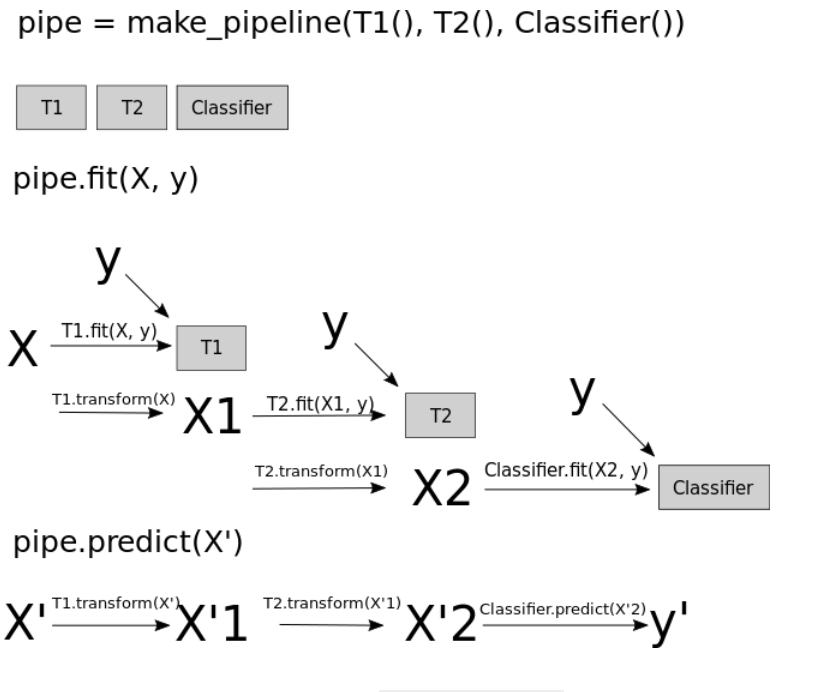

管道实际上比上图更加通用。管道的最后一步不需要具有predict函数，比如说，我们可以创建一个只包含一个缩放器和一个PCA的管道。由于最后一步(PCA) 具有transform方法。所以我们可以对管道调用transform，以得到将PCA.transform应用于前一个步骤处理过的数据后得到的输出。管道的最后一步只需要具有fit方法。

## 1. 用make_pipeline方便地创建管道

利用上述语法创建管道有时有点麻烦，我们通常不需要为每一个步骤提供用户指定的名称。有一个很方便的函数make_pipeline,可以为我们创建管道并根据每个步骤所属的类为其自动命名。make_pipeline的语法如下所示:

In [3]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
# 标准语法
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 缩写语法
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

管道对象pipe_long和 pipe_short的作用完全相同，但 pipe_short的步骤是自动命名的。我们可以通过查看steps属性来查看步骤的名称:

In [4]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


这两个步骤被命名为minmaxscaler和 svc。一般来说，步骤名称只是类名称的小写版本。如果多个步骤属于同一个类，则会附加一个数字：

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


如你所见，第一个StandardScaler步腺被命名为standardscaler-1,而第2个被命名为standardscaler-2.但在这种情况下,使用具有明确名称的Pipeline构建可能更好，以便为每个步骤提供更具语义的名称。

## 2. 访问步骤属性

通常来说，你希望检查管道中某一步骤的属性——比如线性模型的系数或PCA提取的成分。要想访问管道中的步骤，最简单的方法是通过named_steps属性.它是一个字典，将步骤名称映射为估计器：

In [6]:
from sklearn.datasets import load_breast_cancer

# 用前面定义的管道对cancer数据集进行拟合
cancer = load_breast_cancer()
pipe.fit(cancer.data)
# 从pca步骤中提取前两个上成分
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


## 3. 访问网格搜索管道中的属性

前面说过，使用管道的主要原因之就是进行网格搜索。一个常见的任务是在网格搜索内访问管道的某些步骤。我们对cancer数据集上的LogisticRegression分类器进行网格搜索。在将数据传人LogtsticRegression分类器之前，先用Pipeline 和 StandardScaler对数据进行缩放。首先，我们用make_pipeline函数创建一个管道：

In [7]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

接下来,我们创建一个参数网格，前面说过，LogisticRegression需要调节的正则化参数是参数C。我们对这个参数使用对数网格，在0.01和 100之间进行搜索。由于我们使用了make_pipeline函数，所以管道中LogtsticRegresston步骤的名称是小写的类名称logisticRegression。因此，为广调方参数C，必须指定logistic Regression_C 的参数网格:

In [8]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

像往常一样，我们将cancer数据集划分为训练集和测试集，并对网格搜索进行拟合：

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train,y_train)
# GHdSeaschCV找到的最小模型(在所有训练数据上训练得到的模型)保存在grid_best_estimator_中
print("Best estimator: {}".format(grid.best_estimator_))

D:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:

Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


在我们的例子中，best_estimator是一个管道，它包含两个步骤：standardscaler 和 logisticregression，如前所述，我们可以使用管道的named_steps属性来访问 logisticregression 步骤：

In [10]:
print("Logisticregression step:\n {}".format(grid.best_estimator_.named_steps["logisticregression"]) )

Logisticregression step:
 LogisticRegression(C=1)


现在我们得到了训练过的LogisticRegression实例，下面我们可以访问与每个输入特征相关的系数(权重)：

In [11]:
import numpy as np
np.set_printoptions(precision=3, suppress=True, floatmode='fixed')
print("Logistic regression coefficients:\n {}".format(grid.best_estimator_.named_steps["logisticregression"].coef_))


Logistic regression coefficients:
 [[-0.436 -0.343 -0.408 -0.534 -0.150  0.610 -0.726 -0.785  0.039  0.275
  -1.298  0.049 -0.673 -0.934 -0.139  0.450 -0.130 -0.101  0.434  0.716
  -1.091 -1.095 -0.852 -1.064 -0.743  0.073 -0.823 -0.653 -0.644 -0.420]]
